In [1]:
#| default_exp diffusion

TODO:
wandb
CIFAR10 in greyscale
SimpleDiffusion

# Diffusion unet

In [2]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']='1'

In [3]:
#| export
from miniai.imports import *

from einops import rearrange
from fastprogress import progress_bar

In [4]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [5]:
class GPUCUDAMissing(BaseException):
    pass
    
try:
    if torch.cuda.is_available():
        print('# of GPUs available = ', torch.cuda.device_count())
    else:
        raise GPUCUDAMissing
except GPUCUDAMissing:
    print("ERROR: GPU is missing")

# of GPUs available =  1


In [6]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 512
dsd = load_dataset(name)

In [7]:
#| export
def abar(t): return (t*math.pi/2).cos()**2
def inv_abar(x): return x.sqrt().acos()*2/math.pi

def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0,0.999)
    ε = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return (xt, t.to(device)), ε

def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [8]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

dl = dls.train
(xt,t),eps = b = next(iter(dl))

## Train

Based on Diffusers

In [9]:
#| export
def timestep_embedding(tsteps, emb_dim, max_period= 10000):
    exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim//2, device=tsteps.device)
    emb = tsteps[:,None].float() * exponent.exp()[None,:]
    emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
    return F.pad(emb, (0,1,0,0)) if emb_dim%2==1 else emb

In [10]:
#| export
def pre_conv(ni, nf, ks=3, stride=1, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return layers

In [11]:
#| export
def upsample(nf): return nn.Sequential(nn.Upsample(scale_factor=2.), nn.Conv2d(nf, nf, 3, padding=1))

In [12]:
#| export
def lin(ni, nf, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Linear(ni, nf, bias=bias))
    return layers

In [13]:
# This version is giving poor results - use the cell below instead
class SelfAttention(nn.Module):
    def __init__(self, ni, attn_chans):
        super().__init__()
        self.attn = nn.MultiheadAttention(ni, ni//attn_chans, batch_first=True)
        self.norm = nn.BatchNorm2d(ni)

    def forward(self, x):
        n,c,h,w = x.shape
        x = self.norm(x).view(n, c, -1).transpose(1, 2)
        x = self.attn(x, x, x, need_weights=False)[0]
        return x.transpose(1,2).reshape(n,c,h,w)

In [14]:
#| export
class SelfAttention(nn.Module):
    def __init__(self, ni, attn_chans, transpose=True):
        super().__init__()
        self.nheads = ni//attn_chans
        self.scale = math.sqrt(ni/self.nheads)
        self.norm = nn.LayerNorm(ni)
        self.qkv = nn.Linear(ni, ni*3)
        self.proj = nn.Linear(ni, ni)
        self.t = transpose
    
    def forward(self, x):
        n,c,s = x.shape
        if self.t: x = x.transpose(1, 2)
        x = self.norm(x)
        x = self.qkv(x)
        x = rearrange(x, 'n s (h d) -> (n h) s d', h=self.nheads)
        q,k,v = torch.chunk(x, 3, dim=-1)
        s = (q@k.transpose(1,2))/self.scale
        x = s.softmax(dim=-1)@v
        x = rearrange(x, '(n h) s d -> n s (h d)', h=self.nheads)
        x = self.proj(x)
        if self.t: x = x.transpose(1, 2)
        return x

In [15]:
#| export
class SelfAttention2D(SelfAttention):
    def forward(self, x):
        n,c,h,w = x.shape
        return super().forward(x.view(n, c, -1)).reshape(n,c,h,w)

In [16]:
#| export
class EmbResBlock(nn.Module):
    def __init__(self, n_emb, ni, nf=None, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d, attn_chans=0):
        super().__init__()
        if nf is None: nf = ni
        self.emb_proj = nn.Linear(n_emb, nf*2)
        self.conv1 = pre_conv(ni, nf, ks, act=act, norm=norm)
        self.conv2 = pre_conv(nf, nf, ks, act=act, norm=norm)
        self.idconv = fc.noop if ni==nf else nn.Conv2d(ni, nf, 1)
        self.attn = False
        if attn_chans: self.attn = SelfAttention2D(nf, attn_chans)

    def forward(self, x, t):
        inp = x
        x = self.conv1(x)
        emb = self.emb_proj(F.silu(t))[:, :, None, None]
        scale,shift = torch.chunk(emb, 2, dim=1)
        x = x*(1+scale) + shift
        x = self.conv2(x)
        x = x + self.idconv(inp)
        if self.attn: x = x + self.attn(x)
        return x

In [17]:
#| export
def saved(m, blk):
    m_ = m.forward

    @wraps(m.forward)
    def _f(*args, **kwargs):
        res = m_(*args, **kwargs)
        blk.saved.append(res)
        return res

    m.forward = _f
    return m

In [18]:
#| export
class DownBlock(nn.Module):
    def __init__(self, n_emb, ni, nf, add_down=True, num_layers=1, attn_chans=0):
        super().__init__()
        self.resnets = nn.ModuleList([saved(EmbResBlock(n_emb, ni if i==0 else nf, nf, attn_chans=attn_chans), self)
                                      for i in range(num_layers)])
        self.down = saved(nn.Conv2d(nf, nf, 3, stride=2, padding=1), self) if add_down else nn.Identity()

    def forward(self, x, t):
        self.saved = []
        for resnet in self.resnets: x = resnet(x, t)
        x = self.down(x)
        return x

In [19]:
#| export
class UpBlock(nn.Module):
    def __init__(self, n_emb, ni, prev_nf, nf, add_up=True, num_layers=2, attn_chans=0):
        super().__init__()
        self.resnets = nn.ModuleList(
            [EmbResBlock(n_emb, (prev_nf if i==0 else nf)+(ni if (i==num_layers-1) else nf), nf, attn_chans=attn_chans)
            for i in range(num_layers)])
        self.up = upsample(nf) if add_up else nn.Identity()

    def forward(self, x, t, ups):
        for resnet in self.resnets: x = resnet(torch.cat([x, ups.pop()], dim=1), t)
        return self.up(x)

In [20]:
#| export
class EmbUNetModel(nn.Module):
    def __init__( self, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1, attn_chans=8, attn_start=1):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        self.n_temb = nf = nfs[0]
        n_emb = nf*4
        self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                     lin(n_emb, n_emb))
        self.downs = nn.ModuleList()
        n = len(nfs)
        for i in range(n):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=n-1, num_layers=num_layers,
                                        attn_chans=0 if i<attn_start else attn_chans))
        self.mid_block = EmbResBlock(n_emb, nfs[-1])

        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(n):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=n-1, num_layers=num_layers+1,
                                    attn_chans=0 if i>=n-attn_start else attn_chans))
        self.conv_out = pre_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, inp):
        x,t = inp
        temb = timestep_embedding(t, self.n_temb)
        emb = self.emb_mlp(temb)
        x = self.conv_in(x)
        saved = [x]
        for block in self.downs: x = block(x, emb)
        saved += [p for o in self.downs for p in o.saved]
        x = self.mid_block(x, emb)
        for block in self.ups: x = block(x, emb, saved)
        return self.conv_out(x)

In [21]:
#| export
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig, clamp=True):
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
    x_0_hat = ((x_t-(1-abar_t).sqrt()*noise) / abar_t.sqrt())
    if clamp: x_0_hat = x_0_hat.clamp(-1,1)
    if bbar_t1<=sig**2+0.01: sig=0.  # set to zero if very small or NaN
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat,x_t

In [37]:
#| export
@torch.no_grad()
def sample(f, model, sz, steps, eta=1., clamp=True, progress=False):
    model.eval()
    ts = torch.linspace(1-1/steps,0,steps)
    x_t = torch.randn(sz).cuda()
    preds = []
    tbe = progress_bar(ts) if progress else ts 
    for i,t in enumerate(tbe):
        t = t[None].cuda()
        abar_t = abar(t)
        noise = model((x_t, t))
        abar_t1 = abar(t-1/steps) if t>=1/steps else torch.tensor(1)
        x_0_hat,x_t = f(x_t, noise, abar_t, abar_t1, 1-abar_t, 1-abar_t1, eta, 1-((i+1)/100), clamp=clamp)
        preds.append(x_0_hat.float().cpu())
    return preds

In [46]:
import wandb

class WandBCB(MetricsCB):
    order=100
    def __init__(self, config, *ms, project='ddpm_cifar10', **metrics):
        fc.store_attr()
        super().__init__(*ms, **metrics)
        
    def before_fit(self, learn): wandb.init(project=self.project, config=self.config)
    def after_fit(self, learn): wandb.finish()

    def _log(self, d):
        #import pdb; pdb.set_trace()
        if learn.model.training: 
            wandb.log({'train_'+m:float(d[m]) for m in self.all_metrics})
        else: 
            wandb.log({'val_'+m:float(d[m]) for m in self.all_metrics})
            wandb.log({'samples':self.sample_figure(learn)})
        print(d)

        
    def sample_figure(self, learn):
        with torch.no_grad():
            samples = sample(ddim_step, model, (16, 1, 32, 32), steps=100, eta=1.)
        s = (samples[-1]*2).clamp(-1,1)
        plt.clf()
        fig, axs = get_grid(16, imsize=3)
        for im,ax in zip(s[:16], axs.flat): show_image(im, ax=ax)
        return fig

    def after_batch(self, learn):
        super().after_batch(learn) 
        wandb.log({'loss':learn.loss})

In [48]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'comments':'default unet logging test'})
cbs = [DeviceCB(), ProgressCB(plot=True), wandbcb, BatchSchedCB(sched), MixedPrecision()]
model = EmbUNetModel(in_channels=1, out_channels=1, nfs=(32,64,128,256), num_layers=2)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,█▅▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁
val_loss,▁
loss,0.0816
train_loss,0.145
val_loss,0.08


{'loss': '0.143', 'epoch': 0, 'train': 'train'}
{'loss': '0.093', 'epoch': 0, 'train': 'eval'}
{'loss': '0.067', 'epoch': 1, 'train': 'train'}
{'loss': '0.091', 'epoch': 1, 'train': 'eval'}
{'loss': '0.055', 'epoch': 2, 'train': 'train'}
{'loss': '0.054', 'epoch': 2, 'train': 'eval'}
{'loss': '0.047', 'epoch': 3, 'train': 'train'}
{'loss': '0.050', 'epoch': 3, 'train': 'eval'}
{'loss': '0.044', 'epoch': 4, 'train': 'train'}
{'loss': '0.052', 'epoch': 4, 'train': 'eval'}
{'loss': '0.042', 'epoch': 5, 'train': 'train'}
{'loss': '0.047', 'epoch': 5, 'train': 'eval'}
{'loss': '0.040', 'epoch': 6, 'train': 'train'}
{'loss': '0.043', 'epoch': 6, 'train': 'eval'}
{'loss': '0.039', 'epoch': 7, 'train': 'train'}
{'loss': '0.039', 'epoch': 7, 'train': 'eval'}
{'loss': '0.037', 'epoch': 8, 'train': 'train'}
{'loss': '0.042', 'epoch': 8, 'train': 'eval'}
{'loss': '0.037', 'epoch': 9, 'train': 'train'}
{'loss': '0.042', 'epoch': 9, 'train': 'eval'}
{'loss': '0.037', 'epoch': 10, 'train': 'train'}
{

/home/course22p2/miniai/datasets.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)


{'loss': '0.033', 'epoch': 19, 'train': 'eval'}
{'loss': '0.033', 'epoch': 20, 'train': 'train'}
{'loss': '0.033', 'epoch': 20, 'train': 'eval'}
{'loss': '0.032', 'epoch': 21, 'train': 'train'}
{'loss': '0.034', 'epoch': 21, 'train': 'eval'}
{'loss': '0.032', 'epoch': 22, 'train': 'train'}
{'loss': '0.032', 'epoch': 22, 'train': 'eval'}
{'loss': '0.032', 'epoch': 23, 'train': 'train'}
{'loss': '0.032', 'epoch': 23, 'train': 'eval'}
{'loss': '0.032', 'epoch': 24, 'train': 'train'}
{'loss': '0.032', 'epoch': 24, 'train': 'eval'}


loss,█▅▄▃▃▂▃▂▂▂▂▂▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
loss,0.02993
train_loss,0.032
val_loss,0.032


<Figure size 448x336 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

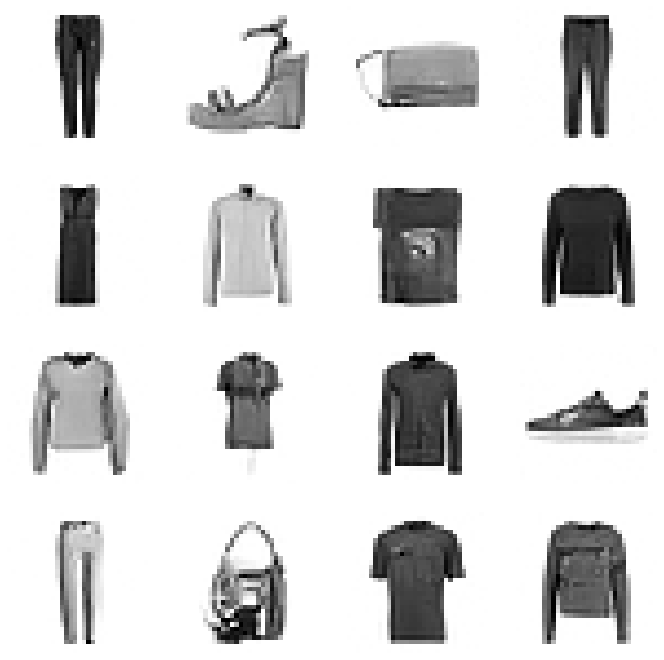

In [49]:
learn.fit(epochs)

## Sampling

In [50]:
from miniai.fid import ImageEval

cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

In [51]:
sz = (64,1,32,32)

In [52]:
# set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1.)
s = (preds[-1]*2)
s.min(),s.max(),s.shape

(tensor(-1.0391), tensor(1.3541), torch.Size([64, 1, 32, 32]))

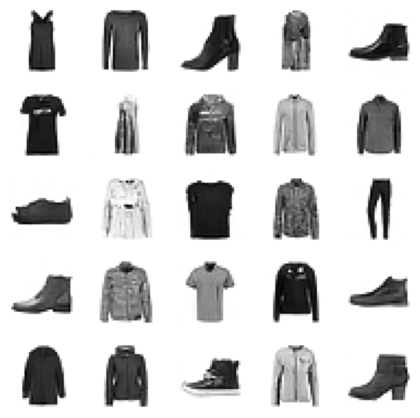

In [53]:
show_images(s[:25].clamp(-1,1), imsize=1.5)